## Extract LDM Latents

In this notebook, we show how to extract unet latents 

Motivated by [Sparse AutoEncoder](https://github.com/openai/sparse_autoencoder) and [Transformer Lens](https://github.com/TransformerLensOrg/TransformerLens)

The outputs are obtained on a TPU v4-8.

In [1]:
# Import Modules
"""
 Copyright 2024 Google LLC

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      https://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
 """

import functools
import os
import time
from typing import Sequence
import sys
sys.path.append(".") # run maxdiffusion codebase in editable mode

import numpy as np

import jax
import jax.numpy as jnp
from maxdiffusion.max_utils import (
  create_device_mesh,
  get_dtype,
  get_states,
  device_put_replicated,
  get_flash_block_sizes
)
from maxdiffusion import pyconfig
from absl import app
from maxdiffusion import (
  FlaxStableDiffusionPipeline,
  FlaxDDIMScheduler,
  FlaxUNet2DConditionModel
)

from maxdiffusion.maxdiffusion_utils import rescale_noise_cfg
from flax.linen import partitioning as nn_partitioning
from jax.experimental.compilation_cache import compilation_cache as cc
from jax.sharding import Mesh, PositionalSharding
from maxdiffusion.image_processor import VaeImageProcessor

cc.set_cache_dir(os.path.expanduser("~/jax_cache"))


2024-07-13 13:54:16.737658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 13:54:16.737718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 13:54:16.738871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 13:54:17.875115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define Functions (capture intermediates in loop_body)
def loop_body(step, args, model, pipeline, prompt_embeds, guidance_scale, guidance_rescale):
    latents, scheduler_state, state, intermediates = args
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = pipeline.scheduler.scale_model_input(scheduler_state, latents_input, t)

    model_out, intermediates = model.apply(
        {"params" : state.params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=prompt_embeds,
        capture_intermediates=True
    )
    noise_pred = model_out.sample

    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
    noise_pred = rescale_noise_cfg(noise_pred, noise_prediction_text, guidance_rescale=guidance_rescale)

    latents, scheduler_state = pipeline.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()

    return latents, scheduler_state, state, intermediates

def tokenize(prompt, tokenizer):
    """Tokenizes prompt."""
    return tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="np"
    ).input_ids

def get_unet_inputs(rng, config, batch_size, pipeline, params):
    vae_scale_factor = 2 ** (len(pipeline.vae.config.block_out_channels) - 1)
    prompt_ids = [config.prompt] * batch_size
    prompt_ids = tokenize(prompt_ids, pipeline.tokenizer)
    negative_prompt_ids = [config.negative_prompt] * batch_size
    negative_prompt_ids = tokenize(negative_prompt_ids, pipeline.tokenizer)
    guidance_scale = config.guidance_scale
    guidance_rescale = config.guidance_rescale
    num_inference_steps = config.num_inference_steps

    prompt_embeds = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
    negative_prompt_embeds = pipeline.text_encoder(negative_prompt_ids, params=params["text_encoder"])[0]
    context = jnp.concatenate([negative_prompt_embeds, prompt_embeds])
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    guidance_rescale = jnp.array([guidance_rescale], dtype=jnp.float32)

    batch_size = prompt_ids.shape[0]
    latents_shape = (
        batch_size,
        pipeline.unet.config.in_channels,
        config.resolution // vae_scale_factor,
        config.resolution // vae_scale_factor,
    )
    latents = jax.random.normal(rng, shape=latents_shape, dtype=jnp.float32)

    scheduler_state = pipeline.scheduler.set_timesteps(
        params["scheduler"],
        num_inference_steps=num_inference_steps,
        shape=latents.shape
    )
    latents = latents * params["scheduler"].init_noise_sigma

    return latents, context, guidance_scale, guidance_rescale, scheduler_state

def vae_decode(latents, state, pipeline):
    latents = 1 / pipeline.vae.config.scaling_factor * latents
    image = pipeline.vae.apply(
        {"params" : state.params},
        latents,
        method=pipeline.vae.decode
    ).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    return image



In [16]:
# Load Configs
argv = 'generate.py maxdiffusion/configs/base15.yml run_name=my_run pretrained_model_name_or_path=sd-model-futurama/futurama/checkpoints/final/'.split(" ")
pyconfig.initialize(argv) # defines a global variable config in the namespace pyconfig
config = pyconfig.config
print("Pretrained model path:",config.pretrained_model_name_or_path)

Pretrained model path: sd-model-futurama/futurama/checkpoints/final/


In [17]:
# Print Configs (optional)
# from pprint import pprint
# pprint(config.get_keys())

## Run LDM Inference in Notebook Environment

In [18]:
# Expose "run" function in the environment
rng = jax.random.PRNGKey(config.seed)
# Setup Mesh
devices_array = create_device_mesh(config)
mesh = Mesh(devices_array, config.mesh_axes)

batch_size = jax.device_count() * config.num_samples_per_device

weight_dtype = get_dtype(config)
flash_block_sizes = get_flash_block_sizes(config)
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    config.pretrained_model_name_or_path,revision=config.revision, dtype=weight_dtype,
    safety_checker=None,
    feature_extractor=None,
    split_head_dim=config.split_head_dim,
    norm_num_groups=config.norm_num_groups,
    from_pt=config.from_pt,
    attention_kernel=config.attention,
    flash_block_sizes=flash_block_sizes,
    mesh=mesh
)
if len(config.unet_checkpoint) > 0:
    unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(
            config.unet_checkpoint,
            split_head_dim=config.split_head_dim,
            norm_num_groups=config.norm_num_groups,
            attention_kernel=config.attention,
            flash_block_sizes=flash_block_sizes,
            mesh=mesh
        )
    params["unet"] = unet_params
    pipeline.unet = unet
scheduler, scheduler_state = FlaxDDIMScheduler.from_pretrained(
    config.pretrained_model_name_or_path, revision=config.revision, subfolder="scheduler", dtype=jnp.float32
)
pipeline.scheduler = scheduler
params = jax.tree_util.tree_map(lambda x: x.astype(weight_dtype), params)
params["scheduler"] = scheduler_state

# Text encoder params
sharding = PositionalSharding(mesh.devices).replicate()
partial_device_put_replicated = functools.partial(device_put_replicated, sharding=sharding)
params["text_encoder"] = jax.tree_util.tree_map(partial_device_put_replicated, params["text_encoder"])

(unet_state,
    unet_state_mesh_shardings,
    vae_state,
    vae_state_mesh_shardings) = get_states(mesh, None, rng, config, pipeline, params["unet"], params["vae"], training=False)
del params["vae"]
del params["unet"]

def run_inference(unet_state, vae_state, params, rng, config, batch_size, pipeline):

    (latents,
    context,
    guidance_scale,
    guidance_rescale,
    scheduler_state) = get_unet_inputs(rng, config, batch_size, pipeline, params)

    loop_body_p = functools.partial(loop_body, model=pipeline.unet,
                                    pipeline=pipeline,
                                    prompt_embeds=context,
                                    guidance_scale=guidance_scale,
                                    guidance_rescale=guidance_rescale)

    vae_decode_p = functools.partial(vae_decode, pipeline=pipeline)
    _, _, _, intermediates = loop_body_p(step=0,args=(latents, scheduler_state,unet_state, None)) # dry run to get intermediates pytree

    with mesh, nn_partitioning.axis_rules(config.logical_axis_rules):
        latents, _, _, intermediates = jax.lax.fori_loop(0, config.num_inference_steps,
                                        loop_body_p, (latents, scheduler_state, unet_state, intermediates))
        image = vae_decode_p(latents, vae_state)
        return image, latents, context, intermediates

p_run_inference = jax.jit(
    functools.partial(run_inference, rng=rng, config=config, batch_size=batch_size, pipeline=pipeline),
    in_shardings=(unet_state_mesh_shardings, vae_state_mesh_shardings, None),
    out_shardings=None
)

print("compilation start...")
s = time.time()
images, latents, context, intermediates = p_run_inference(unet_state, vae_state, params)
images.block_until_ready()
print("compile time: ", (time.time() - s))

s = time.time()
images, latents, context, intermediates = p_run_inference(unet_state, vae_state, params)
images.block_until_ready()
print("inference time: ",(time.time() - s))
numpy_images = np.array(images)
images = VaeImageProcessor.numpy_to_pil(numpy_images)
# for i, image in enumerate(images):
#     image.save(f"image_{i}.png")


Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)] (num_devices: 4)
Decided on mesh: [[[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]]

 [[TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0)]]

 [[TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0)]]

 [[TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]]]


You have disabled the safety checker for <class 'maxdiffusion.pipelines.stable_diffusion.pipeline_flax_stable_diffusion.FlaxStableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


compilation start...
compile time:  23.915318727493286
inference time:  0.6343114376068115


In [19]:
# Get an impression of the module surgery (Optional)
# intermediates['intermediates'].keys()
# jax.tree.map(lambda x: x.shape,intermediates['intermediates'])

In [20]:
# Print model structure (Optional)
# jax.tree.map(lambda x: x.shape,unet_state.params)


In [21]:
# Plot several states
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,3))

# states = intermediates['intermediates']['down_blocks_0']['__call__'][0][1]
# def hist(w):
#     plt.hist(w.flatten(),density=True,bins=30,range=[-5,5])

# for i, w in enumerate(states):
#     plt.subplot(1,len(states),i+1)
#     hist(w)
    
# print("Histogram of Some Hidden States")

In [22]:
# Reproduce "context" variable to make it clear... 
# prompt_ids = tokenize([config.prompt], pipeline.tokenizer)
# prompt_ids

In [23]:
# Language tokens
# c = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
# c.shape

In [24]:
# Covariance Matrix
# M = jnp.einsum('abc,dec->be',c,c)
# plt.figure(figsize=(4,2))
# plt.subplot(121)
# plt.imshow(M);plt.axis('off')
# plt.subplot(122)
# plt.imshow(M[:11,:11]);plt.axis('off')
# print("Covariance Matrix of Language Tokens and Zoom-In of Non-Empty Words")

In [25]:
# Covariance of Attention KVs
# attns = intermediates['intermediates']['down_blocks_0']['attentions_0']['transformer_blocks_0']
# k1 = attns['attn1']['to_k']['__call__'][0]
# v1 = attns['attn1']['to_v']['__call__'][0]
# k2 = attns['attn2']['to_k']['__call__'][0]
# v2 = attns['attn2']['to_v']['__call__'][0]
# cov = lambda x,y: jnp.einsum('abc,dec->be',x,y).astype(jnp.float32)
# Mk1 = cov(k1,k1)
# Mv1 = cov(v1,v1)
# Mk2 = cov(k2,k2)
# Mv2 = cov(v2,v2)
# plt.figure(figsize=(6,6))
# plt.subplot(221)
# plt.imshow(Mk1[:11,:11]);plt.axis('off')
# plt.subplot(222)
# plt.imshow(Mv1[:11,:11]);plt.axis('off')

# plt.subplot(223)
# plt.imshow(Mk2[:11,:11]);plt.axis('off')
# plt.subplot(224)
# plt.imshow(Mv2[:11,:11]);plt.axis('off')
# print("Covariant Matrices of Linear Embeddings in Some Layers. They are equivalent modulo SL(320) and we find some redundancies... Excercise: find more using intermediates!")

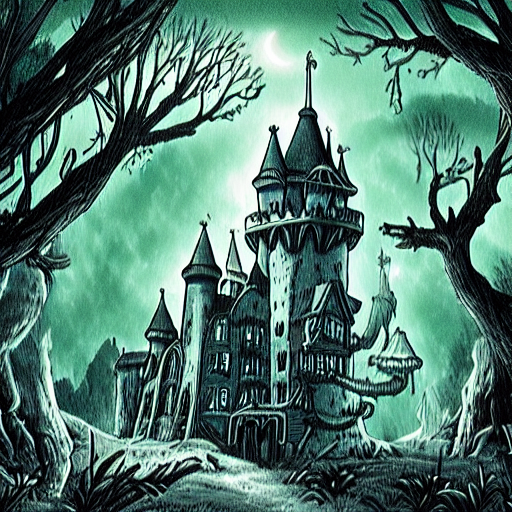

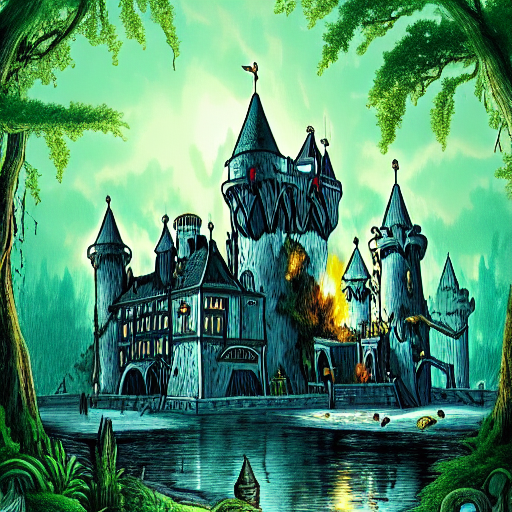

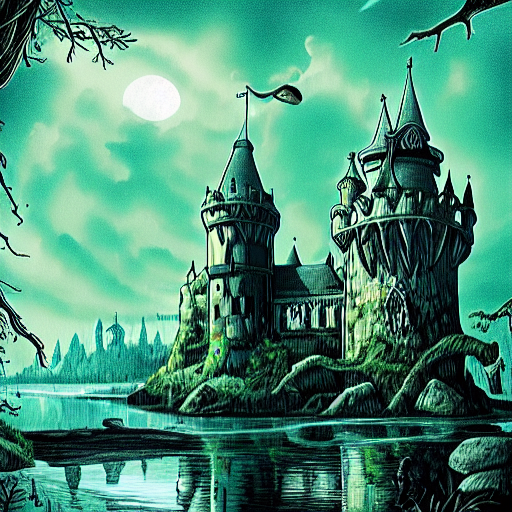

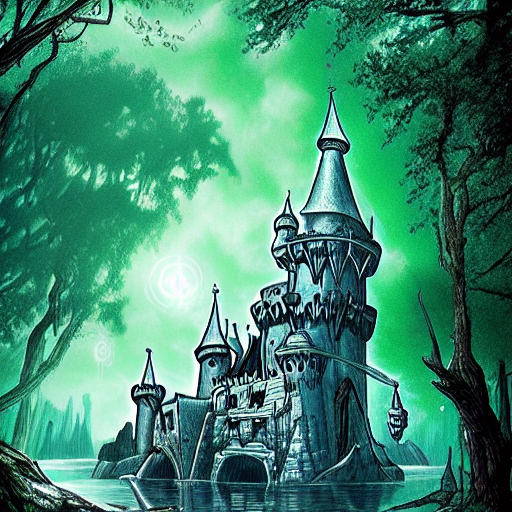

Lastly we show the generated images. Prompt: A magical castle in the middle of a forest, artistic drawing


In [26]:
[display(image) for image in images]
print("Lastly we show the generated images. Prompt:",config.prompt)